In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X.npy')
y=np.load('data_y.npy')

In [3]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    ##featurewise_center=True,
    #featurewise_std_normalization=True, 
    rotation_range=25.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=64)

Using TensorFlow backend.


In [5]:
from keras import layers, models
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
 


pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

W0606 13:58:22.488852  4144 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0606 13:58:22.506855  4144 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0606 13:58:22.511854  4144 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0606 13:58:22.540863  4144 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0606 13:58:22.876284  4144

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [6]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(4, activation='softmax'))

In [7]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='My_VGG_weight_1.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)

In [8]:
from keras import backend as K
import tensorflow as tf

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision


def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

In [9]:
additional_model.compile(loss='categorical_crossentropy',
                         optimizer=optimizers.RMSprop(lr=2e-5), 
                         metrics=['acc', auc, precision, recall, f1score])

W0606 13:58:24.861657  4144 deprecation_wrapper.py:119] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0606 13:58:24.955016  4144 deprecation.py:323] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\tensorflow\python\ops\metrics_impl.py:809: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [10]:
X.shape

(2861, 224, 224, 3)

In [11]:
# history1=myvgg.fit(X,y,batch_size=32,
#                   epochs=100,
#                   validation_split=0.3,
#                   callbacks=[checkpoint])

In [12]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=100, 
            epochs=100, 
            validation_data=(X_val,y_val), 
            validation_steps=16, 
            callbacks=[checkpoint])

W0606 13:58:32.588353  4144 deprecation.py:323] From C:\Users\Owner2\Anaconda3\envs\keras2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
100/100 [==============================] - 58s 582ms/step - loss: 1.1018 - acc: 0.4754 - auc: 0.7190 - precision: 0.5811 - recall: 0.3123 - f1score: 0.3950 - val_loss: 1.1178 - val_acc: 0.4307 - val_auc: 0.7734 - val_precision: 0.4835 - val_recall: 0.2910 - val_f1score: 0.3626
Epoch 2/100
100/100 [==============================] - 53s 535ms/step - loss: 0.9341 - acc: 0.5264 - auc: 0.7918 - precision: 0.6034 - recall: 0.3962 - f1score: 0.4758 - val_loss: 0.8461 - val_acc: 0.5693 - val_auc: 0.8058 - val_precision: 0.6557 - val_recall: 0.4249 - val_f1score: 0.5148
Epoch 3/100
100/100 [==============================] - 55s 546ms/step - loss: 0.8924 - acc: 0.5626 - auc: 0.8145 - precision: 0.6281 - recall: 0.4377 - f1score: 0.5135 - val_loss: 0.8172 - val_acc: 0.5786 - val_auc: 0.8215 - val_precision: 0.6282 - val_recall: 0.4703 - val_f1score: 0.5376
Epoch 4/100
100/100 [==============================] - 55s 547ms/step - loss: 0.8502 - acc: 0.5648 - auc: 0.8273 - precision: 0.63

100/100 [==============================] - 54s 542ms/step - loss: 0.6205 - acc: 0.6927 - auc: 0.8882 - precision: 0.7224 - recall: 0.6560 - f1score: 0.6873 - val_loss: 0.7173 - val_acc: 0.6310 - val_auc: 0.8888 - val_precision: 0.6470 - val_recall: 0.6042 - val_f1score: 0.6248
Epoch 30/100
100/100 [==============================] - 54s 543ms/step - loss: 0.6107 - acc: 0.6959 - auc: 0.8894 - precision: 0.7152 - recall: 0.6544 - f1score: 0.6832 - val_loss: 0.7253 - val_acc: 0.6403 - val_auc: 0.8900 - val_precision: 0.6559 - val_recall: 0.6147 - val_f1score: 0.6345
Epoch 31/100
100/100 [==============================] - 54s 543ms/step - loss: 0.5920 - acc: 0.7014 - auc: 0.8906 - precision: 0.7261 - recall: 0.6709 - f1score: 0.6972 - val_loss: 0.7377 - val_acc: 0.6333 - val_auc: 0.8912 - val_precision: 0.6434 - val_recall: 0.6054 - val_f1score: 0.6236
Epoch 32/100
100/100 [==============================] - 55s 545ms/step - loss: 0.6014 - acc: 0.7023 - auc: 0.8917 - precision: 0.7260 - reca

100/100 [==============================] - 54s 543ms/step - loss: 0.4721 - acc: 0.7820 - auc: 0.9122 - precision: 0.7948 - recall: 0.7651 - f1score: 0.7796 - val_loss: 0.8926 - val_acc: 0.6170 - val_auc: 0.9125 - val_precision: 0.6238 - val_recall: 0.6065 - val_f1score: 0.6150
Epoch 58/100
100/100 [==============================] - 55s 547ms/step - loss: 0.4713 - acc: 0.7723 - auc: 0.9129 - precision: 0.7845 - recall: 0.7540 - f1score: 0.7687 - val_loss: 0.8871 - val_acc: 0.6193 - val_auc: 0.9132 - val_precision: 0.6254 - val_recall: 0.6100 - val_f1score: 0.6175
Epoch 59/100
100/100 [==============================] - 55s 549ms/step - loss: 0.4733 - acc: 0.7755 - auc: 0.9135 - precision: 0.7889 - recall: 0.7605 - f1score: 0.7743 - val_loss: 0.8783 - val_acc: 0.6182 - val_auc: 0.9138 - val_precision: 0.6271 - val_recall: 0.6042 - val_f1score: 0.6153
Epoch 60/100
100/100 [==============================] - 55s 547ms/step - loss: 0.4673 - acc: 0.7837 - auc: 0.9141 - precision: 0.7958 - reca

100/100 [==============================] - 55s 546ms/step - loss: 0.3732 - acc: 0.8285 - auc: 0.9278 - precision: 0.8357 - recall: 0.8198 - f1score: 0.8276 - val_loss: 1.0081 - val_acc: 0.6065 - val_auc: 0.9280 - val_precision: 0.6127 - val_recall: 0.6042 - val_f1score: 0.6084
Epoch 86/100
100/100 [==============================] - 55s 545ms/step - loss: 0.3771 - acc: 0.8371 - auc: 0.9283 - precision: 0.8443 - recall: 0.8309 - f1score: 0.8375 - val_loss: 1.1714 - val_acc: 0.6042 - val_auc: 0.9285 - val_precision: 0.6077 - val_recall: 0.5995 - val_f1score: 0.6035
Epoch 87/100
100/100 [==============================] - 54s 544ms/step - loss: 0.3595 - acc: 0.8326 - auc: 0.9287 - precision: 0.8396 - recall: 0.8251 - f1score: 0.8322 - val_loss: 1.0510 - val_acc: 0.6228 - val_auc: 0.9289 - val_precision: 0.6309 - val_recall: 0.6123 - val_f1score: 0.6214
Epoch 88/100
100/100 [==============================] - 55s 547ms/step - loss: 0.3624 - acc: 0.8414 - auc: 0.9292 - precision: 0.8473 - reca

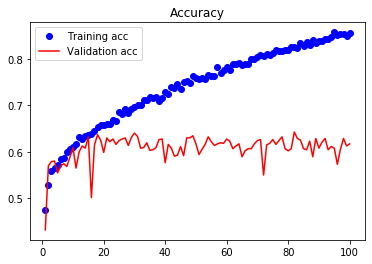

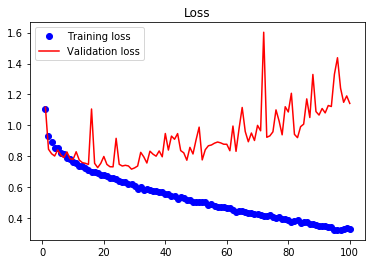

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [15]:
additional_model.save('fine_tuning_VGG16_Aug_1.h5')

In [16]:
X_test=np.load('X_test.npy')
y_test=np.load('y_test.npy')

In [18]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_test, y_test, batch_size=64)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

704/704 [==============================] - 2s 3ms/step
loss: 11.608, accuracy: 0.280, auc: 0.934, precision: 0.280, recall: 0.280, f1score: 0.280


In [19]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=64)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

859/859 [==============================] - 2s 3ms/step
loss: 1.142, accuracy: 0.617, auc: 0.934, precision: 0.619, recall: 0.611, f1score: 0.615
